In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.datasets import boston_housing

(data_train, targets_train), (data_test, targets_test) = boston_housing.load_data()

data_train.shape, data_train[0]

65536/57026 [==================================] - 0s 1us/step


((404, 13),
 array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
         91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
         18.72   ]))

In [2]:
targets_train[0]

15.2

In [3]:
mean = data_train.mean(axis=0)
std = data_train.std(axis=0)

In [4]:
data_train = (data_train-mean) / std
data_test = (data_train-mean) / std

In [5]:
def build_model():
    model = keras.models.Sequential([
        Dense(64, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    model.compile(
        optimizer='rmsprop',
        loss='mse',
        metrics='mae'
    )
    
    return model

k-fold validation

In [6]:
import numpy as np

k = 4
num_val_samples = len(data_train) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('Processing fold ', i)
    val_data = data_train[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = targets_train[i * num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [data_train[:i * num_val_samples], data_train[(i + 1) * num_val_samples:]], axis=0
    )
    partial_train_targets = np.concatenate(
        [targets_train[:i * num_val_samples], targets_train[(i + 1) * num_val_samples:]], axis=0
    )
    
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

Processing fold  0
Processing fold  1
Processing fold  2
Processing fold  3


In [7]:
all_scores

[1.9645189046859741, 2.4641151428222656, 2.3767552375793457, 2.485994577407837]

In [9]:
np.mean(all_scores)

2.3228459656238556

In [11]:
num_epochs = 500
all_scores = []
all_mae_histories=[]

for i in range(k):
    print('Processing fold ', i)
    val_data = data_train[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = targets_train[i * num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [data_train[:i * num_val_samples], data_train[(i + 1) * num_val_samples:]], axis=0
    )
    partial_train_targets = np.concatenate(
        [targets_train[:i * num_val_samples], targets_train[(i + 1) * num_val_samples:]], axis=0
    )
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=16, verbose=0, validation_data=(val_data, val_targets))
    all_mae_histories.append(history.history['val_mae'])

Processing fold  0
Processing fold  1
Processing fold  2
Processing fold  3


In [13]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

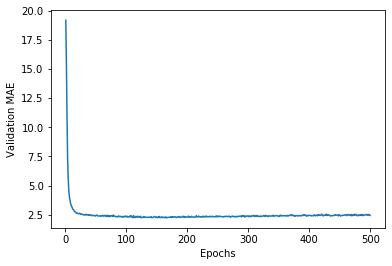

In [14]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

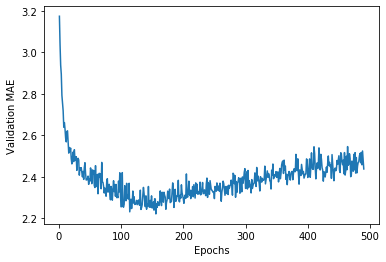

In [15]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [16]:
predictions = model.predict(data_test)
predictions[0]


array([68.63806], dtype=float32)